In [1]:
from fastai.vision.all import *

In [2]:
pd.options.display.max_columns = 100

In [6]:
embspath = Path("/../rsna_data/cnn_embs/")
datapath = Path("/../rsna_data/")
train_df = pd.read_csv(datapath/'train.csv')

In [7]:
list(embspath.ls())

[Path('/../rsna_data/cnn_embs/raw512_fold0'),
 Path('/../rsna_data/cnn_embs/.ipynb_checkpoints'),
 Path('/../rsna_data/cnn_embs/sample_files_fold0.pkl'),
 Path('/../rsna_data/cnn_embs/sample_raw512_fold0'),
 Path('/../rsna_data/cnn_embs/sample_raw512_fold0.pkl')]

### Visual Embeddings

In [15]:
embs = torch.load(embspath/'sample_raw512_fold0.pkl')
# train_preds = torch.load(embspath/'cnn_preds.pkl')
files = pd.read_pickle(embspath/'sample_files_fold0.pkl') # files in same order as embs

In [62]:
embs.shape

torch.Size([24479, 1024])

In [63]:
# add padding embedding and idx
embs_len = len(embs)
input_pad_idx = embs_len
embs = torch.cat([embs, torch.zeros_like(embs[:1])])

In [64]:
embs[input_pad_idx], embs.shape, input_pad_idx

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), torch.Size([24480, 1024]), 24479)

In [33]:
pids = np.random.permutation(list(set([o.parent.name for o in files])))

In [34]:
train_pids, valid_pids = pids[20:], pids[:20]

In [35]:
len(train_pids), len(valid_pids)

(80, 20)

### Metadata

In [37]:
metadata_path = datapath/'metadata'
train_metadata_paths = [o for o in metadata_path.ls() if o.stem in train_pids]
valid_metadata_paths = [o for o in metadata_path.ls() if o.stem in valid_pids]

In [39]:
train_metadf = pd.concat([pd.read_csv(o) for o in train_metadata_paths]).reset_index(drop=True)
valid_metadf = pd.concat([pd.read_csv(o) for o in valid_metadata_paths]).reset_index(drop=True)

In [40]:
train_metadf.shape, valid_metadf.shape

((20010, 65), (4469, 60))

In [41]:
train_meta_feats = train_metadf[['StudyInstanceUID', 'SOPInstanceUID', 'ImagePositionPatient2', 'img_min', 'img_max', 'img_mean', 'img_std', 'img_pct_window']]
valid_meta_feats = valid_metadf[['StudyInstanceUID', 'SOPInstanceUID', 'ImagePositionPatient2', 'img_min', 'img_max', 'img_mean', 'img_std', 'img_pct_window']]

In [42]:
def minmax_scaler(o): return (o - min(o))/(max(o) - min(o))

In [43]:
scaled_pos = train_meta_feats.groupby('StudyInstanceUID')['ImagePositionPatient2'].apply(minmax_scaler)
train_meta_feats.loc[:,'scaled_position'] = scaled_pos.values
scaled_pos = valid_meta_feats.groupby('StudyInstanceUID')['ImagePositionPatient2'].apply(minmax_scaler)
valid_meta_feats.loc[:,'scaled_position'] = scaled_pos.values

/app/python/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/app/python/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
train_meta_feats.isna().sum(), valid_meta_feats.isna().sum()

(StudyInstanceUID         0
 SOPInstanceUID           0
 ImagePositionPatient2    0
 img_min                  0
 img_max                  0
 img_mean                 0
 img_std                  0
 img_pct_window           0
 scaled_position          0
 dtype: int64,
 StudyInstanceUID         0
 SOPInstanceUID           0
 ImagePositionPatient2    0
 img_min                  0
 img_max                  0
 img_mean                 0
 img_std                  0
 img_pct_window           0
 scaled_position          0
 dtype: int64)

In [45]:
meta_feats = ['img_min', 'img_max', 'img_mean', 'img_std', 'scaled_position', 'img_pct_window']
mean_std = {}
for f in meta_feats:
    mean,std = train_meta_feats[f].mean(), train_meta_feats[f].std()
    train_meta_feats[f] = (train_meta_feats[f] - mean) / std
    valid_meta_feats[f] = (valid_meta_feats[f] - mean) / std
    mean_std[f] = (mean, std)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
mean_std

{'img_min': (-1506.8734132933532, 879.5640527002232),
 'img_max': (3189.6404297851072, 1200.9200638029927),
 'img_mean': (163.576680021653, 277.5182815333577),
 'img_std': (979.1473392408714, 296.6841963947724),
 'scaled_position': (0.50866259366971, 0.2909626606483906),
 'img_pct_window': (0.4255562835190071, 0.11475461398819674)}

In [47]:
meta_train_feats_dict = dict(zip(train_meta_feats['SOPInstanceUID'], train_meta_feats[meta_feats].to_numpy()))
meta_valid_feats_dict = dict(zip(valid_meta_feats['SOPInstanceUID'], valid_meta_feats[meta_feats].to_numpy()))

In [48]:
meta_feats_dict = {**meta_train_feats_dict, **meta_valid_feats_dict}

In [49]:
len(meta_feats_dict)

24479

In [54]:
embs.shape, len(files)

(torch.Size([24479, 1024]), 24479)

In [55]:
files[0]

Path('/../rsna_data/full_raw_512/fb54d8356a08/84_8e345cfc080b.jpg')

In [56]:
meta_embs = np.vstack([meta_feats_dict[o.stem.split("_")[1]] for o in files])

In [57]:
meta_embs.shape

(24479, 6)

In [58]:
meta_embs

array([[-0.56064886, -0.80574924, -0.50619338,  0.78242123, -0.5552436 ,
         0.36559698],
       [-0.56064886,  0.75388829, -0.9314688 ,  0.60380516,  1.17739189,
        -0.80885039],
       [-0.56064886, -0.70749124, -0.54970851,  0.74865718, -0.22859921,
         0.26341041],
       ...,
       [ 1.71320486, -0.50597908,  0.76635488, -1.79235579,  0.11906852,
        -1.070932  ],
       [ 1.71320486, -0.84821668,  0.98522382, -1.69499378, -0.94987834,
        -0.43846566],
       [ 1.71320486,  0.02111678,  0.85161927, -1.76238397,  0.47087381,
        -0.831854  ]])

In [59]:
meta_embs = tensor(np.vstack((meta_embs, np.zeros((1,meta_embs.shape[1])))))

In [60]:
meta_embs.shape

torch.Size([24480, 6])

### Dataloaders

In [65]:
from fastai.text.all import *

In [67]:
# Exam-level labels dict
train_df_indexed = train_df.set_index("SOPInstanceUID")
train_df_dict = dict(zip(train_df_indexed.index, train_df_indexed.values))
cols = list(train_df_indexed.columns)
train_df_indexed.values

array([['6897fa9de148', '2bfbb7fd2e8b', 0, ..., 0, 0, 0],
       ['6897fa9de148', '2bfbb7fd2e8b', 0, ..., 0, 0, 0],
       ['6897fa9de148', '2bfbb7fd2e8b', 0, ..., 0, 0, 0],
       ...,
       ['4833c9b6a5d0', '57e3e3c5f910', 0, ..., 0, 0, 0],
       ['4833c9b6a5d0', '57e3e3c5f910', 0, ..., 0, 0, 0],
       ['4833c9b6a5d0', '57e3e3c5f910', 1, ..., 0, 0, 0]], dtype=object)

In [70]:
files_dict = defaultdict(list)
for emb_idx, file in enumerate(files):
    slice_no, sopid = file.stem.split("_")
    slice_no = int(slice_no)    
    files_dict[train_df_dict[sopid][0]].append(({**dict(zip(cols, train_df_dict[sopid])), **{"slice_no":slice_no, "embs_idx":emb_idx}}))

In [71]:
len(files_dict)

100

In [72]:
image_targets = L(['pe_present_on_image'])
exam_targets = L([
#           'positive_exam_for_pe'
            'negative_exam_for_pe',
            'indeterminate',

            'rv_lv_ratio_gte_1',
            'rv_lv_ratio_lt_1',
    # none

            'leftsided_pe',
            'rightsided_pe',
            'central_pe',

            'chronic_pe',
            'acute_and_chronic_pe',           
            # neither chronic or acute_and_chronic
          
    
    
#             'qa_motion',
#             'qa_contrast',
#             'flow_artifact',
#             'true_filling_defect_not_pe',
             ]); exam_targets

(#9) ['negative_exam_for_pe','indeterminate','rv_lv_ratio_gte_1','rv_lv_ratio_lt_1','leftsided_pe','rightsided_pe','central_pe','chronic_pe','acute_and_chronic_pe']

In [73]:
def get_x(pid):
    o = files_dict[pid]    
    l = sorted(o, key=lambda x: x['slice_no']) 
    return tensor([o['embs_idx'] for o in l])

def get_img_y(pid):
    o = files_dict[pid]    
    l = sorted(o, key=lambda x: x['slice_no']) 
    img_y = [o['pe_present_on_image'] for o in l]
    exam_y = [max(img_y)] + [o[0][t] for t in exam_targets]
    return tensor(img_y)

def get_exam_y(pid):
    """
    'POSITIVE','negative_exam_for_pe','indeterminate',
    'rv_lv_ratio_gte_1','rv_lv_ratio_lt_1', 'NEITHER'
    'leftsided_pe','rightsided_pe','central_pe',
    'chronic_pe','acute_and_chronic_pe','NEITHER'
    """
    o = files_dict[pid]    
    l = sorted(o, key=lambda x: x['slice_no']) 
    img_y = [o['pe_present_on_image'] for o in l]
    
    exam_y = [max(img_y)] + [o[0][t] for t in exam_targets]
    
    none_chro_acute = [exam_y[-1] == exam_y[-2]]
    exam_y += none_chro_acute
    
    none_rv_lv = [exam_y[3] == exam_y[4]]
    exam_y = exam_y[:4] + none_rv_lv + exam_y[4:]
    
    
    return tensor(exam_y)

# before_batch: after collecting samples before collating
targ_pad_idx = 666
def SequenceBlock():       return  TransformBlock(type_tfms=[get_x], dl_type=SortedDL, dls_kwargs={'before_batch':
                                                       [partial(pad_input, pad_idx=input_pad_idx),
                                                        partial(pad_input, pad_idx=targ_pad_idx, pad_fields=1)]})
def SequenceTargetBlock(): return TransformBlock(type_tfms=[get_img_y])
def TargetBlock():         return TransformBlock(type_tfms=[get_exam_y])

In [74]:
trn_pid = np.random.choice(train_pids)

In [75]:
get_x(trn_pid)

tensor([482, 434, 352, 348, 254, 439, 264, 316, 407, 347, 267, 433, 253, 386,
        411, 370, 481, 289, 354, 277, 414, 290, 405, 353, 274, 382, 376, 249,
        250, 463, 396, 449, 360, 262, 271, 285, 476, 258, 446, 397, 294, 444,
        380, 461, 308, 423, 445, 393, 408, 329, 387, 467, 243, 261, 302, 255,
        440, 278, 301, 475, 357, 251, 421, 320, 428, 395, 442, 455, 284, 263,
        441, 379, 469, 451, 448, 474, 275, 378, 312, 282, 310, 391, 322, 259,
        361, 272, 454, 424, 332, 349, 245, 317, 280, 368, 406, 480, 344, 465,
        452, 453, 394, 390, 276, 260, 324, 431, 311, 306, 472, 279, 252, 286,
        373, 473, 339, 297, 299, 256, 270, 314, 450, 325, 288, 460, 268, 456,
        266, 429, 443, 438, 327, 343, 247, 363, 365, 464, 273, 315, 300, 304,
        367, 330, 326, 374, 336, 291, 296, 342, 398, 385, 366, 410, 483, 359,
        303, 470, 427, 318, 447, 401, 244, 377, 269, 478, 437, 436, 413, 362,
        420, 337, 418, 415, 426, 468, 355, 402, 364, 338, 246, 4

In [76]:
get_img_y(trn_pid)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])

In [77]:
get_exam_y(trn_pid)

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [78]:
len(train_pids), len(valid_pids)

(80, 20)

In [102]:
default_device(0)

device(type='cpu')

In [103]:
data = DataBlock(blocks=(SequenceBlock,SequenceTargetBlock,TargetBlock), 
                 n_inp=1, 
                 splitter=FuncSplitter(lambda o: o in valid_pids))
dls = data.dataloaders(list(train_pids)+list(valid_pids), bs=4)
b = dls.one_batch()

In [104]:
learner = Learner(dls, nn.Linear(10,10), loss_func=noop)
learner._split(b)
len(learner.xb), len(learner.yb)

(1, 2)

In [105]:
learner.xb[0].shape, learner.yb[0].shape, learner.yb[1].shape

(torch.Size([4, 1056]), torch.Size([4, 1056]), torch.Size([4, 12]))

In [106]:
embs[learner.xb[0]].shape, meta_embs[learner.xb[0]].shape

(torch.Size([4, 1056, 1024]), torch.Size([4, 1056, 6]))

In [107]:
torch.cat([embs[learner.xb[0]], meta_embs[learner.xb[0]]], -1).shape

torch.Size([4, 1056, 1030])

### Model

In [108]:
device = default_device(); device

device(type='cpu')

In [122]:
class MultiHeadedSequenceClassifier(Module):
    "dim: input sequence feature dim"
    def __init__(self, embs, meta_embs, input_pad_idx=input_pad_idx, n_meta=6, dim=1024):
        store_attr('embs,meta_embs,input_pad_idx')
        
        self.lstm1 = nn.LSTM(dim+n_meta, dim//16, bidirectional=True)
        
        # image level preds
        self.seq_cls_head = nn.Linear(dim//8, 1)
    
        
        # positive, negative, indeterminate
        self.pe_head = nn.Linear(dim//4, 3) # softmax
        # rv / lv >=,  < 1 or neither
        self.rv_lv_head = nn.Linear(dim//4, 3) # softmax
        # l,r,c pe
        self.pe_position_head = nn.Linear(dim//4, 3) # sigmoid
        # chronic, ac-chr or neither
        self.chronic_pe_head = nn.Linear(dim//4, 3) # softmax
        
    
    def forward(self, x):
        
        # get mask from non-pad idxs and then features
        mask = x != self.input_pad_idx
        x = torch.cat([self.embs[x], self.meta_embs[x]], dim=-1).to(device)
        
        # sequence outs
        x, _ = self.lstm1(x) 

        seq_cls_out = self.seq_cls_head(x).squeeze(-1)
        
        
        #masked concat pool
        pooled_x = []
        for i in range(x.size(0)):
            xi = x[i, mask[i], :]
            pooled_x.append(torch.cat([xi.mean(0), xi.max(0).values]).unsqueeze(0))
        pooled_x = torch.cat(pooled_x)
        

        # 'POSITIVE','negative_exam_for_pe','indeterminate'
        out1 = self.pe_head(pooled_x)

        # 'rv_lv_ratio_gte_1','rv_lv_ratio_lt_1', 'NEITHER'
        out2 = self.rv_lv_head(pooled_x)

        # 'leftsided_pe','rightsided_pe','central_pe',
        out3 = self.pe_position_head(pooled_x)

        # 'chronic_pe','acute_and_chronic_pe','NEITHER'
        out4 = self.chronic_pe_head(pooled_x)

        return (seq_cls_out, out1, out2, out3, out4)

In [123]:
# model = MultiHeadedSequenceClassifier()

In [124]:
# outs = model(*learner.xb)

In [125]:
class MultiLoss(Module):
    
    def __init__(self, targ_pad_idx=666):
        store_attr("targ_pad_idx")
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.ce_loss = CrossEntropyLossFlat()

    def forward(self, inp, yb0, yb1):

        seq_cls_out, out1, out2, out3, out4 = inp

        mask = yb0 != self.targ_pad_idx
        loss0 = self.bce_loss(seq_cls_out[mask], yb0[mask].float())


        # loss 1 p/n/i
        loss1 = self.ce_loss(out1, torch.where(yb1[:,:3])[1])

        # loss 2 rv/lv/neither
        loss2 = self.ce_loss(out2, torch.where(yb1[:,3:6])[1])

        # loss 3 L/R/C
        loss3 = self.bce_loss(out3, yb1[:,6:9].float())

        # loss 3 chro/acute/neither
        loss4 = self.ce_loss(out4, torch.where(yb1[:,9:])[1])

        
        return (loss0 + loss1 + loss2 + loss3 + loss4) / 5

In [126]:
# loss_func = MultiLoss()

In [127]:
# loss = loss_func(outs, *learner.yb); loss

### Metric

In [128]:
# 'POSITIVE','negative_exam_for_pe','indeterminate',
# 'rv_lv_ratio_gte_1','rv_lv_ratio_lt_1', 'NEITHER'
# 'leftsided_pe','rightsided_pe','central_pe',
# 'chronic_pe','acute_and_chronic_pe','NEITHER'

In [129]:
# bce_loss = BCEWithLogitsLossFlat()

In [130]:
# seq_cls_out, out1, out2, out3, out4 = outs
# yb0, yb1 = learner.yb

In [131]:
neg_pe_wgt = 0.0736196319
indeterminate_wgt = 0.09202453988

rv_lv_gte_1_wgt = 0.2346625767
rv_lv_lt_1_wgt = 0.0782208589

left_pe_wgt = 0.06257668712
right_pe_wgt = 0.06257668712
central_pe_wgt = 0.1877300613

chronic_wgt = 0.1042944785
acute_chronic_wgt = 0.1042944785

bce_loss = BCEWithLogitsLossFlat()

def metric(preds, yb0, yb1):
    
    seq_cls_out, out1, out2, out3, out4 = preds
    
    bs = out1.size(0)
    
    out1 = F.softmax(out1, 1)
    out2 = F.softmax(out2, 1)
    out3 = torch.sigmoid(out3)
    out4 = F.softmax(out4, 1)
    
    neg_pe_loss = F.binary_cross_entropy(out1[:,1], yb1[:,1].float())
    indeterminate_loss = F.binary_cross_entropy(out1[:,2], yb1[:,2].float())

    rv_lv_gte_1_loss = F.binary_cross_entropy(out2[:,0], yb1[:,3].float())
    rv_lv_lt_1_loss = F.binary_cross_entropy(out2[:,1], yb1[:,4].float())

    left_pe_wgt = F.binary_cross_entropy(out3[:,0], yb1[:,6].float())
    right_pe_wgt = F.binary_cross_entropy(out3[:,0], yb1[:,7].float())
    central_pe_wgt = F.binary_cross_entropy(out3[:,0], yb1[:,8].float())

    chronic_loss = F.binary_cross_entropy(out4[:,0], yb1[:,9].float())
    acute_chronic_loss = F.binary_cross_entropy(out4[:,1], yb1[:,10].float())

    
    tot_exam_loss = 0
    tot_exam_wgts = 0

    tot_exam_loss += neg_pe_loss*bs*neg_pe_wgt
    tot_exam_loss += indeterminate_loss*bs*indeterminate_wgt
    tot_exam_loss += rv_lv_gte_1_loss*bs*rv_lv_gte_1_wgt
    tot_exam_loss += rv_lv_lt_1_loss*bs*rv_lv_lt_1_wgt
    tot_exam_loss += left_pe_wgt*bs*left_pe_wgt
    tot_exam_loss += right_pe_wgt*bs*right_pe_wgt
    tot_exam_loss += central_pe_wgt*bs*central_pe_wgt
    tot_exam_loss += chronic_loss*bs*chronic_wgt
    tot_exam_loss += acute_chronic_loss*bs*acute_chronic_wgt

    tot_exam_wgts += bs*neg_pe_wgt
    tot_exam_wgts += bs*indeterminate_wgt
    tot_exam_wgts += bs*rv_lv_gte_1_wgt
    tot_exam_wgts += bs*rv_lv_lt_1_wgt
    tot_exam_wgts += bs*left_pe_wgt
    tot_exam_wgts += bs*right_pe_wgt
    tot_exam_wgts += bs*central_pe_wgt
    tot_exam_wgts += bs*chronic_wgt
    tot_exam_wgts += bs*acute_chronic_wgt

    tot_exam_loss, tot_exam_wgts = tot_exam_loss.item(), tot_exam_wgts.item()
    
    
    
    # Image-level weighted log loss (single batch)
    w_img = 0.07361963
    tot_img_loss = 0
    tot_img_wgts = 0
    for img_preds, img_targs in zip(seq_cls_out, yb0):
        mask = img_targs != targ_pad_idx
        img_preds = img_preds[mask]
        img_targs = img_targs[mask]

        n_imgs = sum(mask)

        qi = img_targs.float().mean()    
        img_loss = bce_loss(img_preds, img_targs)    
        wgt = w_img*qi
        tot_img_wgts += (wgt).item()*n_imgs
        tot_img_loss += (wgt*img_loss).item()*n_imgs

    
    return (tot_exam_loss + tot_img_loss) / (tot_exam_wgts + tot_img_wgts)

### Train

In [132]:
device = default_device(1); device
# device = default_device(0); device

device(type='cuda', index=0)

In [133]:
data = DataBlock(blocks=(SequenceBlock,SequenceTargetBlock,TargetBlock), 
                 n_inp=1, splitter=FuncSplitter(lambda o: o in valid_pids))
dls = data.dataloaders(list(train_pids)+list(valid_pids), bs=32)
model = MultiHeadedSequenceClassifier(embs, meta_embs, dim=1024)
loss_func = MultiLoss()
learner = Learner(dls, model, loss_func=loss_func, metrics=[metric], cbs=[SaveModelCallback(fname="best_seqmodel")])
# learner.to_fp16();

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0012022644514217973)

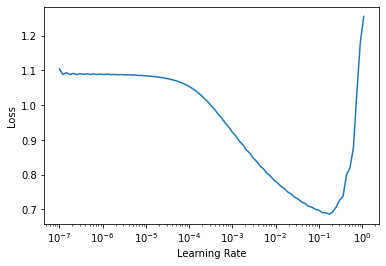

In [134]:
learner.lr_find()

In [135]:
learner.fit_flat_cos(100, lr=0.02)

epoch,train_loss,valid_loss,metric,time
0,0.871136,0.573141,0.599327,00:01
1,0.685530,0.587882,0.627316,00:01
2,0.616821,0.572953,0.639064,00:01
3,0.578582,0.576877,0.703715,00:01
4,0.555719,0.570155,0.747177,00:01
5,0.538599,0.575892,0.720264,00:01
6,0.527166,0.572708,0.697612,00:01
7,0.517126,0.561454,0.691056,00:01
8,0.508961,0.557920,0.684135,00:01
9,0.502103,0.562567,0.645345,00:01


Better model found at epoch 0 with valid_loss value: 0.5731411576271057.
Better model found at epoch 2 with valid_loss value: 0.5729528069496155.
Better model found at epoch 4 with valid_loss value: 0.5701550245285034.
Better model found at epoch 7 with valid_loss value: 0.5614535212516785.
Better model found at epoch 8 with valid_loss value: 0.5579198002815247.
Better model found at epoch 10 with valid_loss value: 0.552874743938446.
Better model found at epoch 11 with valid_loss value: 0.5419058799743652.
Better model found at epoch 14 with valid_loss value: 0.5342854857444763.
Better model found at epoch 19 with valid_loss value: 0.5253738760948181.
Better model found at epoch 22 with valid_loss value: 0.5201585292816162.
Better model found at epoch 23 with valid_loss value: 0.5164654850959778.
Better model found at epoch 33 with valid_loss value: 0.5164469480514526.
Better model found at epoch 36 with valid_loss value: 0.5163021087646484.
Better model found at epoch 39 with valid_lo

Exception ignored in: <function _releaseLock at 0x7f4130128710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


IndexError: list index out of range